<a href="https://colab.research.google.com/github/secoxx/IE423/blob/main/task_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialize

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import scale

## Load Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [31]:
df =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/black_friday/train.csv')

In [6]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [9]:
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [10]:
df.isna().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

It seems there are null values in Product_Category_2 and Product_Category_3 columns. The other columns have full information.

In [11]:
df.nunique()

User_ID                        5891
Product_ID                     3631
Gender                            2
Age                               7
Occupation                       21
City_Category                     3
Stay_In_Current_City_Years        5
Marital_Status                    2
Product_Category_1               20
Product_Category_2               17
Product_Category_3               15
Purchase                      18105
dtype: int64

## Prepare Data

We create a grouped dataframe that has how many times a user bought a product and the total amount of their purchase for all users.

In [32]:
# Aggregate by customer ID
dfGrouped = (df.groupby(['User_ID','Gender','Age','Occupation','City_Category','Stay_In_Current_City_Years','Marital_Status'],as_index=False).agg({'User_ID':'value_counts','Purchase':'sum'}).rename(columns={'User_ID':'Count'})
            )

dfGrouped

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Count,Purchase
0,F,0-17,10,A,2,0,35,334093
1,M,55+,16,C,4+,0,77,810472
2,M,26-35,15,A,3,0,29,341635
3,M,46-50,7,B,2,1,14,206468
4,M,26-35,20,A,1,1,106,821001
...,...,...,...,...,...,...,...,...
5886,F,26-35,15,B,4+,1,514,4116058
5887,F,46-50,1,C,4+,0,122,1119538
5888,F,55+,1,C,2,0,12,90034
5889,F,46-50,0,B,4+,1,74,590319


In [22]:
# Scale data

X = dfGrouped.copy()
X[X.columns] = scale(X[X.columns])

We're going to do unsupervised learning since we have no info on how these customers would be clustered.

Text(0, 0.5, 'Purchase')

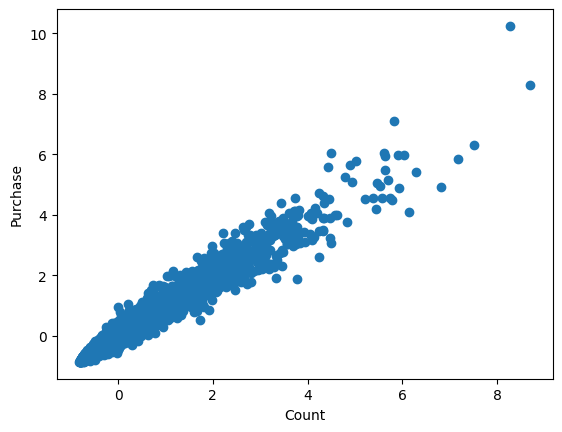

In [23]:
# Visualize scatterplot

plt.scatter(X['Count'],X['Purchase'])
plt.xlabel('Count')
plt.ylabel('Purchase')

It looks like purchase count and total purchase amount are directly linearly correlated. But we can cluster them based on other features such as age, gender, occupation etc.

## EDA

In [47]:

fig = px.histogram(dfGrouped, x="Age", y="Purchase",
             color='Gender', barmode='group')
fig.show()

We see that age draws out almost a normal curve. Ages 26-35 have the most purchases and total purchase amount decrease both ways when age decreases or increases from 26-35. In terms of gender, we see that men have purchased more. But also as we can see below, we had more males than females in our dataset to begin with so this result is expected.

<Axes: xlabel='Gender'>

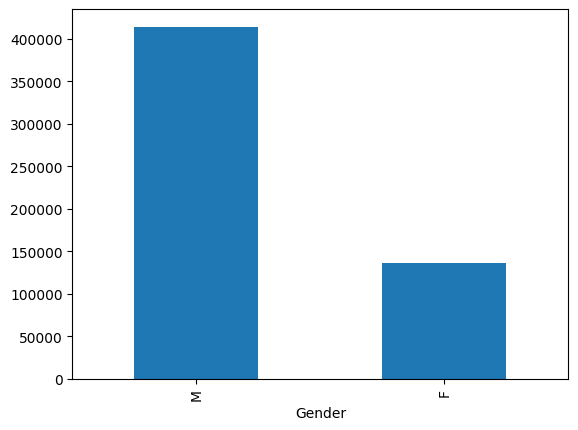

In [50]:
df.value_counts('Gender').plot(kind='bar')

In [56]:
fig = px.pie(dfGrouped,values='Purchase',names='City_Category')
fig.show()

In [57]:
fig = px.histogram(dfGrouped,x='Occupation',y='Purchase',color='Gender')
fig.show()

### K-Means Clustering

In [66]:
# Build k-Means Clustering model

from sklearn.cluster import KMeans

mdlKmc = KMeans(n_clusters=4, random_state=1)
mdlKmc.fit(X)
kMeans_labels = mdlKmc.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Text(0.5, 1.0, 'K-Means Clustering')

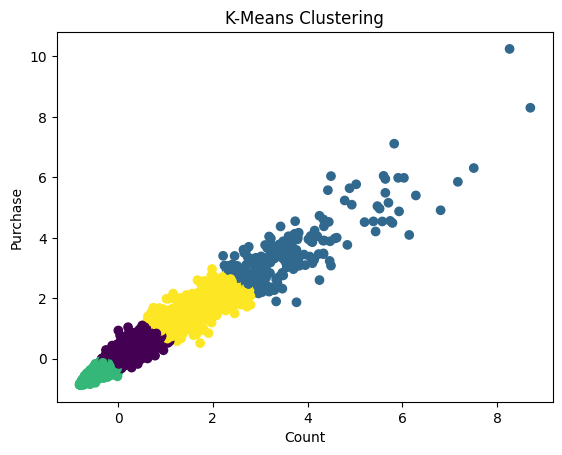

In [67]:
# Display k-Means cluster on scatter plot

plt.scatter(X['Count'],X['Purchase'],c=kMeans_labels)
plt.xlabel('Count')
plt.ylabel('Purchase')
plt.title('K-Means Clustering')

In [68]:
# Evaluate quality of clusters
from sklearn.metrics import silhouette_score

silhouette_score(X, mdlKmc.labels_)

0.6076933751194181

When I tested the silhouette scores, I saw that 2 clusters resulted in a silhouette score of 72%, 3 clusters resulted in 66% and 4 clusters resulted in 60%. I've already said that there's a linear correlation between purchase count and total purchase amount, and I think that's why clustering doesn't result in the scores we'd like to see. Because the data doesnt't show a sparse trend, clustering may not be the best fit. Instead it shows a linear trend, which makes a linear model more suitable.

### Hierarchical Clustering

In [69]:
# Generate linkages between data points
from scipy.cluster import hierarchy

Z = hierarchy.linkage(X, 'ward')

Text(0.5, 1.0, 'Hierarchical Clustering')

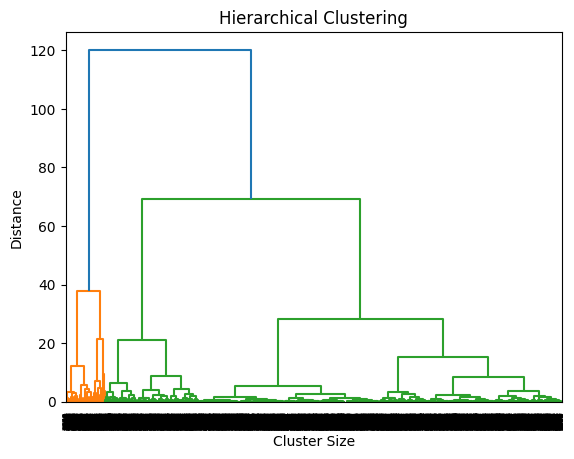

In [70]:
# Visualize Dendrogram of Clusters

hierarchy.dendrogram(Z)
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering')

Dendrogram suggests that 3 clusters are optimal, but let's discover it further with the Agglomerative Clustering function so we don't have to infer from the dendrogram only.

In [81]:
# Build Hierarchical Clustering model
from sklearn.cluster import AgglomerativeClustering

mdlHrc = AgglomerativeClustering(n_clusters=2)
mdlHrc.fit(X)
hClust_labels = mdlHrc.labels_

In [82]:
silhouette_score(X, mdlHrc.labels_)

0.7454258816188772

Text(0.5, 1.0, 'Hierarchical Clustering')

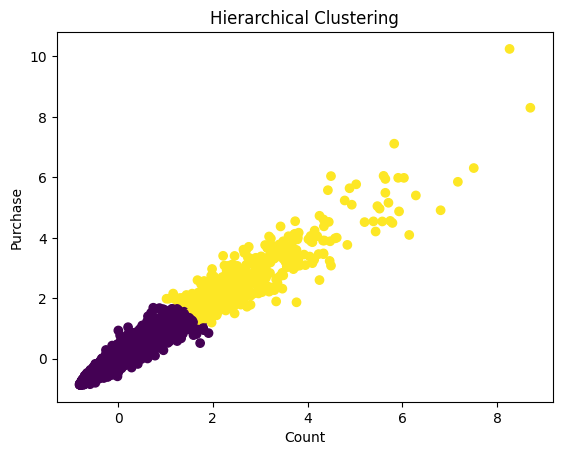

In [83]:
# Display Hierarchical cluster on scatter plot

plt.scatter(X['Count'],X['Purchase'],c=hClust_labels)
plt.xlabel('Count')
plt.ylabel('Purchase')
plt.title('Hierarchical Clustering')

In [79]:
# Function for Hierarchical Clustering
def cluster_hierarchy(X, k):
    mdlHrc = AgglomerativeClustering(n_clusters=k)
    mdlHrc.fit(X)
    hClust_labels = mdlHrc.labels_
    hClust_sil_score = silhouette_score(X, mdlHrc.labels_)
    return (hClust_labels, hClust_sil_score)

In [80]:
# Iterate over different values of k to determine best silhouette score

for k in [2, 3, 4, 5, 6]:
    hClust_labels, hClust_sil_score = cluster_hierarchy(X,k)
    print('k: ',k,'\t\t', 'Silhouette Score: ', hClust_sil_score)

k:  2 		 Silhouette Score:  0.7454258816188772
k:  3 		 Silhouette Score:  0.6415136338507116
k:  4 		 Silhouette Score:  0.6399901867458228
k:  5 		 Silhouette Score:  0.506267207431757
k:  6 		 Silhouette Score:  0.5070500323467254


The ideal cluster size is shown to be 2 in hierarchical clustering as well.

### DBScan Clustering and Anomaly Detection

In [92]:
# Build DBScan model

from sklearn.cluster import DBSCAN

mdlDbs = DBSCAN(eps=0.3)
mdlDbs.fit(X)
dbscan_labels = mdlDbs.labels_

In [93]:
silhouette_score(X, dbscan_labels)

0.8024435045110658

In [94]:
# calculate number of clusters
dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
dbscan_clusters

1

In [95]:
# calculate number of anomalies
dbscan_anomalies = list(dbscan_labels).count(-1)
dbscan_anomalies

40

Text(0.5, 1.0, 'DBScan Clustering')

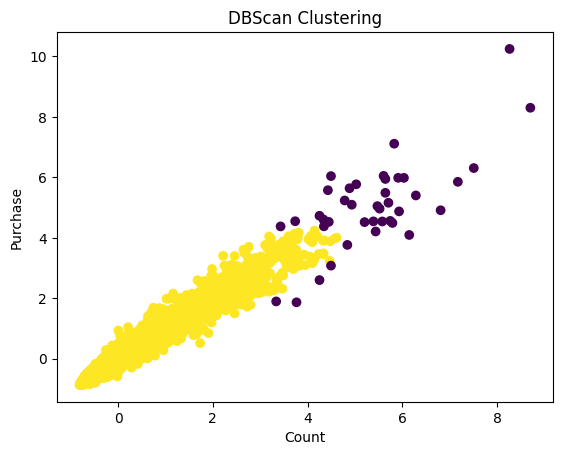

In [96]:
# Display DBScan cluster on scatter plot

plt.scatter(X['Count'],X['Purchase'],c=dbscan_labels)
plt.xlabel('Count')
plt.ylabel('Purchase')
plt.title('DBScan Clustering')

In [89]:
# Function for DBScan Clustering

def cluster_dbscan(X, e):
    mdlDbs = DBSCAN(eps=e)
    mdlDbs.fit(X)
    dbscan_labels = mdlDbs.labels_
    dbscan_sil_score = silhouette_score(X, dbscan_labels)

    # count number of clusters and noise points
    dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    dbscan_anomalies = list(dbscan_labels).count(-1)
    return(dbscan_clusters, dbscan_anomalies, dbscan_sil_score)

In [90]:
# Iterate over different values of eps to determine best silhouette score

for eps in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    dbscan_clusters, dbscan_anomalies, dbscan_sil_score = cluster_dbscan(X, eps)
    print('eps: ',eps,'\t', 'Clusters: ', dbscan_clusters, '\t', 'Noise: ', dbscan_anomalies, '\t', 'Silhouette Score: ', dbscan_sil_score)

eps:  0.1 	 Clusters:  10 	 Noise:  255 	 Silhouette Score:  0.5661972006437398
eps:  0.2 	 Clusters:  4 	 Noise:  60 	 Silhouette Score:  0.6568861530009426
eps:  0.3 	 Clusters:  1 	 Noise:  40 	 Silhouette Score:  0.8024435045110658
eps:  0.4 	 Clusters:  3 	 Noise:  20 	 Silhouette Score:  0.7872811055480032
eps:  0.5 	 Clusters:  3 	 Noise:  15 	 Silhouette Score:  0.7927236996940684
eps:  0.6 	 Clusters:  3 	 Noise:  7 	 Silhouette Score:  0.7943119387842261
eps:  0.7 	 Clusters:  2 	 Noise:  6 	 Silhouette Score:  0.8011975322057425


DBScan gave us the highest silhouette score with 80.2% with 1 cluster and 40 noise (outlier) points. However, if the 40 points were classified as another cluster, then we'de have 2 clusters with less noise. This alternative is given in eps=0.7, where 2 clusters with 6 noise points give a silhouette score of 80.1%, which is very close to the highest result. It comes down to how much noise the user is okay with. However since the silhouette scores are very close, it looks like 2 clusters is the preferable choice. We also got out highest result with the DBScan method. With hierarchical clustering we could only get 74% with 2 clusters and with K-means we got 72% with 2 clusters. With DBScan we got 80% with 2 clusters.

## Conclusion

* By the scatterplots, we had seen that our dataset shows a linear relation between the number of purchases and total purchase amount.
* By the bar plots, we saw that age exhibits a normal distribution with respect to purchase.
* When we tried to cluster, we saw that K-means and hierarchical clustering resulted in 72 and 74% silhouette scores respectively. We got the best silhouette score with DBScan, which resulted in 80%. This means that density based clustering was the most suitable type of clustering for our data at hand.  
* We saw that 2 clusters decreased the noise but 1 cluster resulted in the same silhouette score as well.